In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torchviz

2.8.0+cu126
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#dataset: Breaking Bad



In [ ]:
import json
import os
import os.path as osp
from typing import Callable, List, Optional, Union

import torch

from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from torch_geometric.io import fs, read_txt_array


class BreakBad(InMemoryDataset):
    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {'Solid_obj': 'solid','Not_Solid_obj': 'not_solid'}



    seg_classes = {'Solid_obj': [0, 1],'Not_Solid_obj': [2, 3]}

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return len(self.seg_classes)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {'solid': 0,'not_solid':1}
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = torch.tensor(rank_ids[cat])
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [ ]:
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import ShapeNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, knn_interpolate
from torch_geometric.typing import WITH_TORCH_CLUSTER
from torch_geometric.utils import scatter


In [ ]:
!rm -rf /content/data

In [ ]:
!unzip /content/solid_all_class.zip -d /content/temp_extract
!mkdir /content/data
!mkdir /content/data/raw
!mv /content/temp_extract/solid_all_class/* /content/data/raw
!rm -r /content/temp_extract

Archive:  /content/solid_all_class.zip
   creating: /content/temp_extract/solid_all_class/
   creating: /content/temp_extract/solid_all_class/not_solid/
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_22.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_41.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_59.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_70.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_72.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_75.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_fractured_76.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_sf_piece_0_mode_11.txt  
  inflating: /content/temp_extract/solid_all_class/not_solid/101902_

In [ ]:
category = None  # Pass in `None` to train on all categories.
path = "/content/data"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])
pre_transform = T.NormalizeScale()
train_dataset = BreakBad(path, category, split='trainval', transform=transform,
                         pre_transform=pre_transform)
test_dataset = BreakBad(path, category, split='test',
                        pre_transform=pre_transform)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True,
                          num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False,
                         num_workers=2)

['Solid_obj', 'Not_Solid_obj']


Processing...


['Solid_obj', 'Not_Solid_obj']


Done!


In [ ]:
from collections import Counter

# Count class frequencies
class_counts = Counter(train_dataset.data.y.tolist())
num_classes = train_dataset.num_classes
total = sum(class_counts.values())

# Inverse frequency (or other schemes, e.g., sqrt)
weights = torch.zeros(num_classes, dtype=torch.float)
for i in range(num_classes):
    weights[i] = total / (num_classes * class_counts.get(i, 1))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = weights.to(device)
print(weights)

tensor([1.0325, 0.9694], device='cuda:0')


/tmp/ipython-input-55-2038149116.py:4: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  class_counts = Counter(train_dataset.data.y.tolist())


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import torch
import random
import numpy as np

# Color map: [class 0 (blue), class 1 (orange)]
gt_cmap = np.array([
    [[0.121, 0.466, 0.705]],
    [[1.000, 0.498, 0.054]],
])

@torch.no_grad()
def visualize_ground_truth_3d(loader, num_samples=4):
    all_data = list(loader)
    sampled_data = random.sample(all_data, min(num_samples, len(all_data)))
    sample_id = 1

    for data in sampled_data:
        data = data.to(device)

        sizes = (data.ptr[1:] - data.ptr[:-1]).tolist()
        xs = data.pos.split(sizes)
        ys = data.y

        for x, y in zip(xs, ys):
            x_np = x.cpu().numpy()
            y_np = y.cpu().numpy()
            colors = gt_cmap[y_np]

            print(f"Unique classes: {y_np}")

            fig = plt.figure(figsize=(6, 5))
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(x_np[:, 0], x_np[:, 1], x_np[:, 2], c=colors, s=5)
            ax.set_title(f'Ground Truth - Sample {sample_id} - Class {y_np}')
            ax.set_axis_off()
            plt.tight_layout()
            plt.show()

            sample_id += 1
            if sample_id > num_samples:
                return


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Unique classes: 0


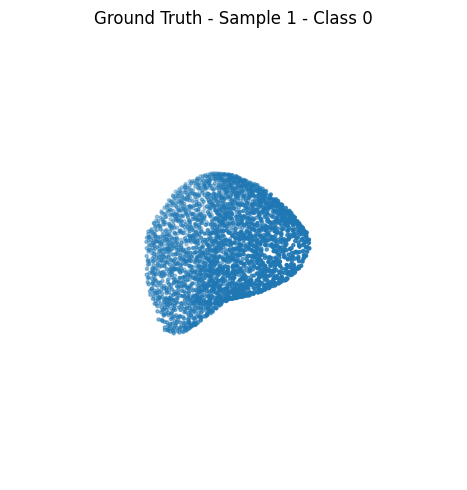

Unique classes: 0


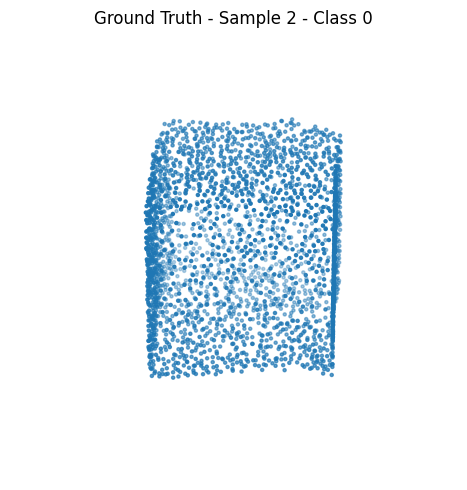

Unique classes: 0


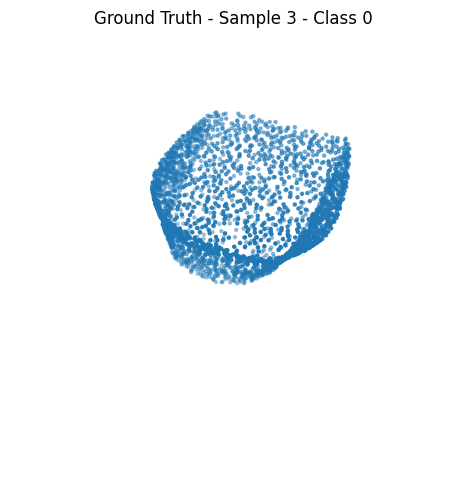

Unique classes: 0


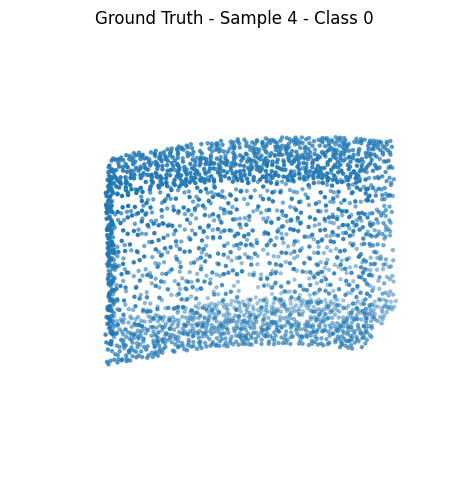

Unique classes: 0


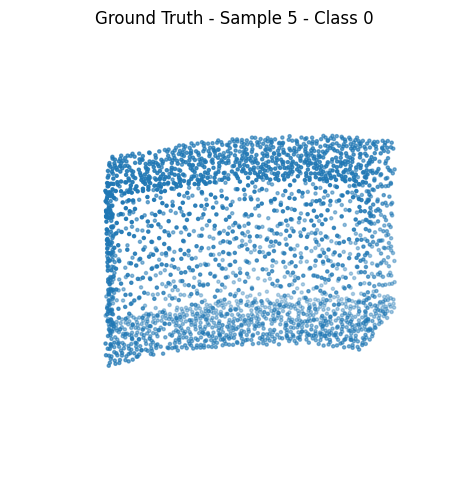

Unique classes: 0


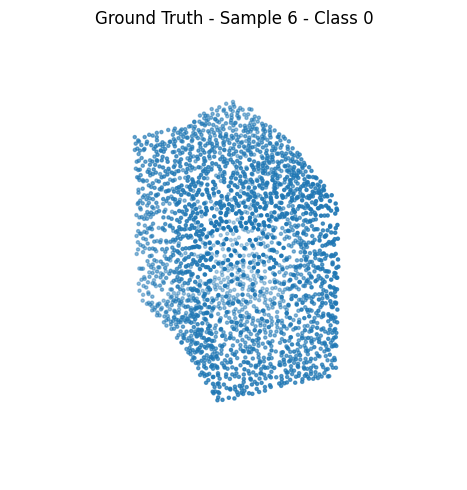

Unique classes: 0


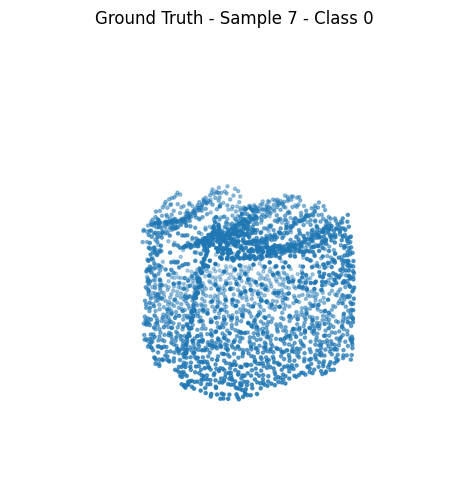

Unique classes: 0


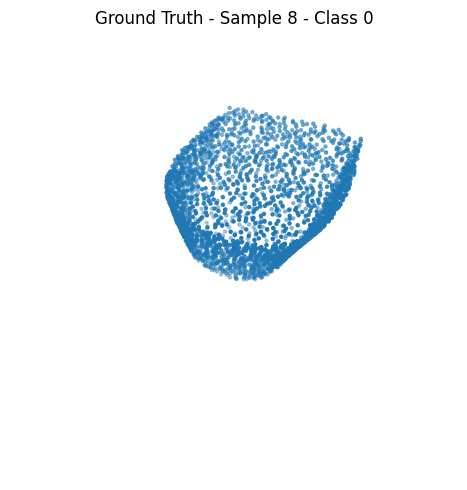

Unique classes: 0


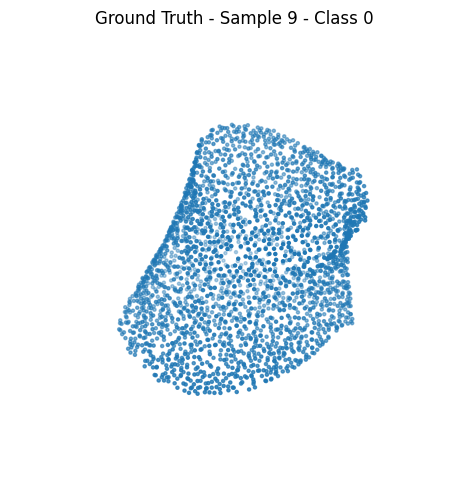

Unique classes: 0


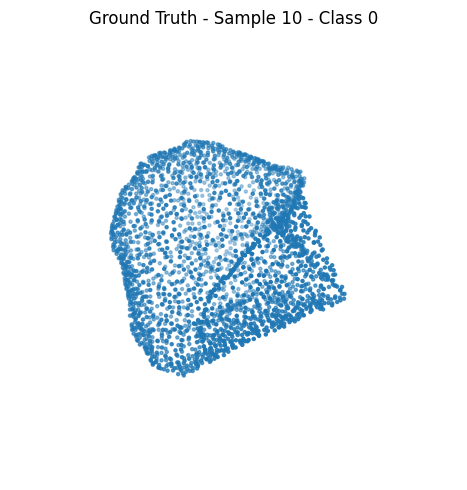

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
visualize_ground_truth_3d(test_loader, num_samples=10)

#PTF Architecture


In [ ]:
from torch_geometric.nn import (
    MLP,
    PointTransformerConv,
    fps,
    global_mean_pool,
    knn,
    knn_graph,)


from torch.nn import Linear as Lin

class TransformerBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.lin_in = Lin(in_channels, in_channels)
        self.lin_out = Lin(out_channels, out_channels)

        self.pos_nn = MLP([3, 64, out_channels], norm=None, plain_last=False)

        self.attn_nn = MLP([out_channels, 64, out_channels], norm=None,
                           plain_last=False)

        self.transformer = PointTransformerConv(in_channels, out_channels,
                                                pos_nn=self.pos_nn,
                                                attn_nn=self.attn_nn)

    def forward(self, x, pos, edge_index):
        x = self.lin_in(x).relu()
        x = self.transformer(x, pos, edge_index)
        x = self.lin_out(x).relu()
        return x


class TransitionDown(torch.nn.Module):
    """Samples the input point cloud by a ratio percentage to reduce
    cardinality and uses an mlp to augment features dimensionnality.
    """
    def __init__(self, in_channels, out_channels, ratio=0.25, k=16):
        super().__init__()
        self.k = k
        self.ratio = ratio
        self.mlp = MLP([in_channels, out_channels], plain_last=False)

    def forward(self, x, pos, batch):
        # FPS sampling
        id_clusters = fps(pos, ratio=self.ratio, batch=batch)

        # compute for each cluster the k nearest points
        sub_batch = batch[id_clusters] if batch is not None else None

        # beware of self loop
        id_k_neighbor = knn(pos, pos[id_clusters], k=self.k, batch_x=batch,
                            batch_y=sub_batch)

        # transformation of features through a simple MLP
        x = self.mlp(x)

        # Max pool onto each cluster the features from knn in points
        x_out = scatter(x[id_k_neighbor[1]], id_k_neighbor[0], dim=0,
                        dim_size=id_clusters.size(0), reduce='max')

        # keep only the clusters and their max-pooled features
        sub_pos, out = pos[id_clusters], x_out
        return out, sub_pos, sub_batch



class TransitionUp(torch.nn.Module):
    """Reduce features dimensionality and interpolate back to higher
    resolution and cardinality.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mlp_sub = MLP([in_channels, out_channels], plain_last=False)
        self.mlp = MLP([out_channels, out_channels], plain_last=False)

    def forward(self, x, x_sub, pos, pos_sub, batch=None, batch_sub=None):
        # transform low-res features and reduce the number of features
        x_sub = self.mlp_sub(x_sub)

        # interpolate low-res feats to high-res points
        x_interpolated = knn_interpolate(x_sub, pos_sub, pos, k=3,
                                         batch_x=batch_sub, batch_y=batch)

        x = self.mlp(x) + x_interpolated

        return x


class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dim_model, k=16):
        super().__init__()
        self.k = k

        # dummy feature is created if there is none given
        in_channels = max(in_channels, 1)

        # first block
        self.mlp_input = MLP([in_channels, dim_model[0]], plain_last=False)

        self.transformer_input = TransformerBlock(in_channels=dim_model[0],
                                                  out_channels=dim_model[0])
        # backbone layers
        self.transformers_down = torch.nn.ModuleList()
        self.transition_down = torch.nn.ModuleList()

        for i in range(len(dim_model) - 1):
            # Add Transition Down block followed by a Transformer block
            self.transition_down.append(
                TransitionDown(in_channels=dim_model[i],
                               out_channels=dim_model[i + 1], k=self.k))

            self.transformers_down.append(
                TransformerBlock(in_channels=dim_model[i + 1],
                                 out_channels=dim_model[i + 1]))

        # class score computation
        self.mlp_output = MLP([dim_model[-1], 64, out_channels], norm=None)

    def forward(self, x, pos, batch=None):

        # add dummy features in case there is none
        if x is None:
            x = torch.ones((pos.shape[0], 1), device=pos.get_device())

        # first block
        x = self.mlp_input(x)
        edge_index = knn_graph(pos, k=self.k, batch=batch)
        x = self.transformer_input(x, pos, edge_index)

        # backbone
        for i in range(len(self.transformers_down)):
            x, pos, batch = self.transition_down[i](x, pos, batch=batch)

            edge_index = knn_graph(pos, k=self.k, batch=batch)
            x = self.transformers_down[i](x, pos, edge_index)

        # GlobalAveragePooling
        x = global_mean_pool(x, batch)

        # Class score
        out = self.mlp_output(x)

        return F.log_softmax(out, dim=-1)


# train


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(3, train_dataset.num_classes,
                dim_model=[32, 64, 128, 256, 512], k=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.7)


In [ ]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.pos, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.pos, data.batch).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)


In [ ]:
for epoch in range(1, 101):
        loss = train()
        test_acc = test(test_loader)
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}')
        scheduler.step()


Epoch 001, Loss: 0.6353, Test: 0.7523
Epoch 002, Loss: 0.5610, Test: 0.6102
Epoch 003, Loss: 0.5249, Test: 0.7741
Epoch 004, Loss: 0.5134, Test: 0.7942
Epoch 005, Loss: 0.4867, Test: 0.7395
Epoch 006, Loss: 0.5063, Test: 0.6903
Epoch 007, Loss: 0.4747, Test: 0.8179
Epoch 008, Loss: 0.4795, Test: 0.7505
Epoch 009, Loss: 0.4890, Test: 0.7814
Epoch 010, Loss: 0.4634, Test: 0.7923
Epoch 011, Loss: 0.4802, Test: 0.7377
Epoch 012, Loss: 0.4638, Test: 0.8197
Epoch 013, Loss: 0.4707, Test: 0.7486
Epoch 014, Loss: 0.4892, Test: 0.7687
Epoch 015, Loss: 0.4930, Test: 0.7814
Epoch 016, Loss: 0.4501, Test: 0.8069
Epoch 017, Loss: 0.4499, Test: 0.8342
Epoch 018, Loss: 0.4419, Test: 0.8415
Epoch 019, Loss: 0.4368, Test: 0.8087
Epoch 020, Loss: 0.4356, Test: 0.8361
Epoch 021, Loss: 0.4673, Test: 0.8270
Epoch 022, Loss: 0.4459, Test: 0.8124
Epoch 023, Loss: 0.4498, Test: 0.8306
Epoch 024, Loss: 0.4340, Test: 0.8251
Epoch 025, Loss: 0.4459, Test: 0.8361
Epoch 026, Loss: 0.4410, Test: 0.8251
Epoch 027, L

Epoch 001, Loss: 0.3882, Test: 0.8415


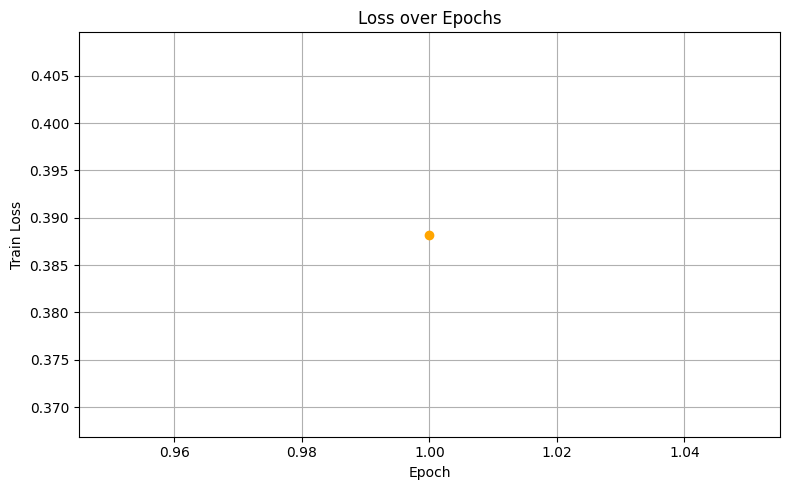

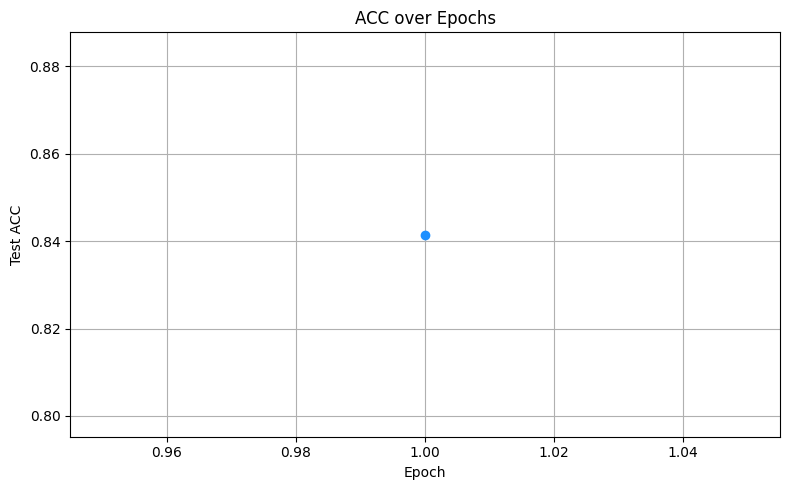

  >> Best model saved at epoch 1 with IoU: 0.8415
Epoch 002, Loss: 0.3920, Test: 0.8087


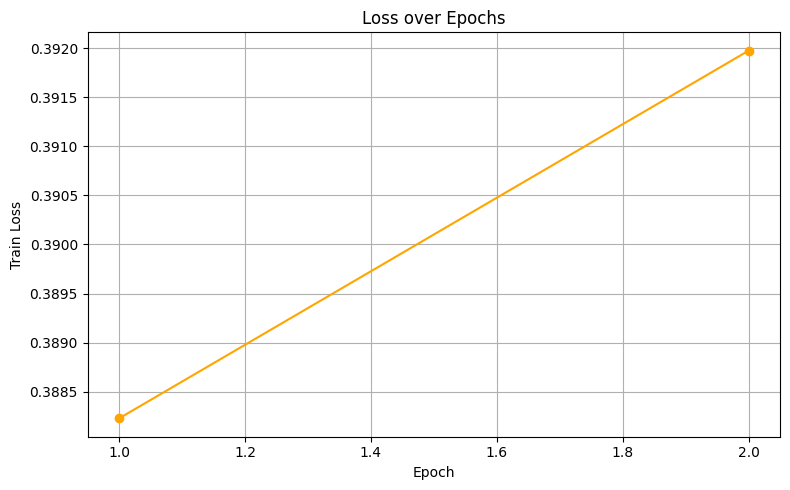

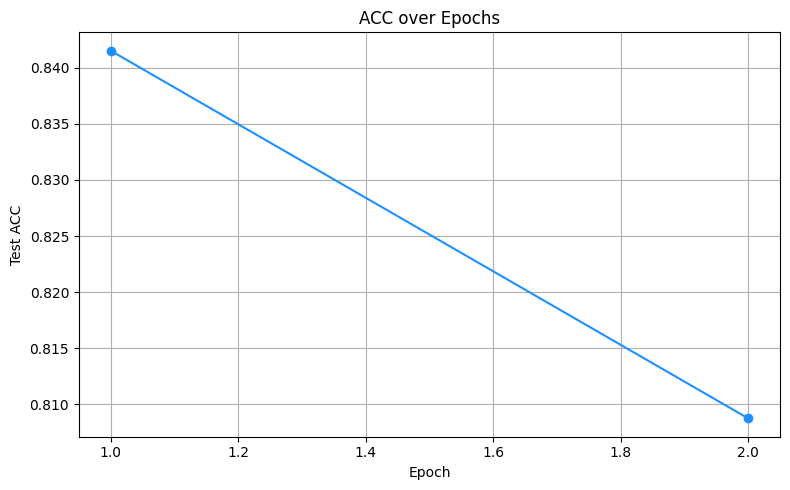

Epoch 003, Loss: 0.4326, Test: 0.8106


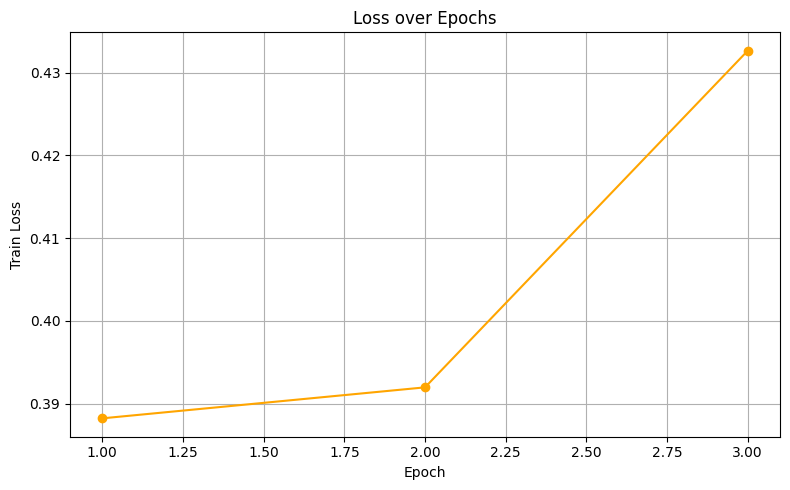

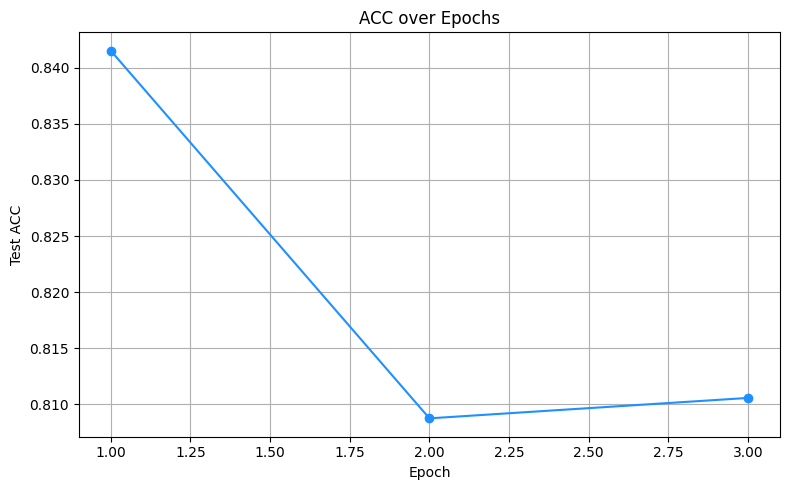

Epoch 004, Loss: 0.4177, Test: 0.8087


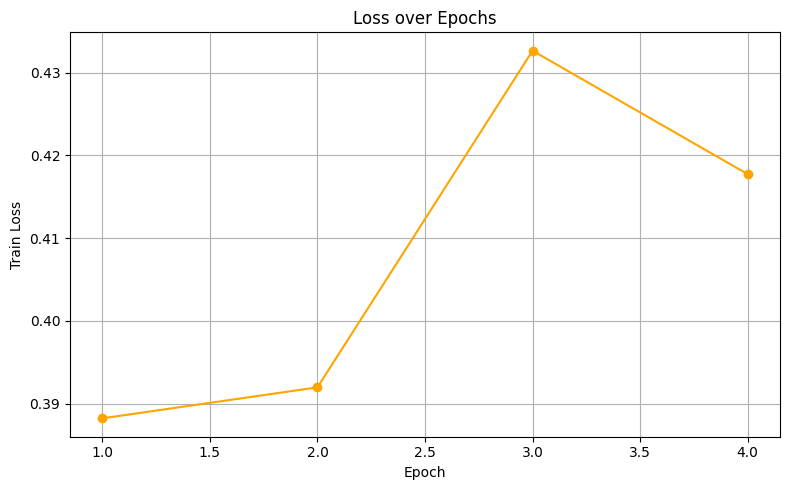

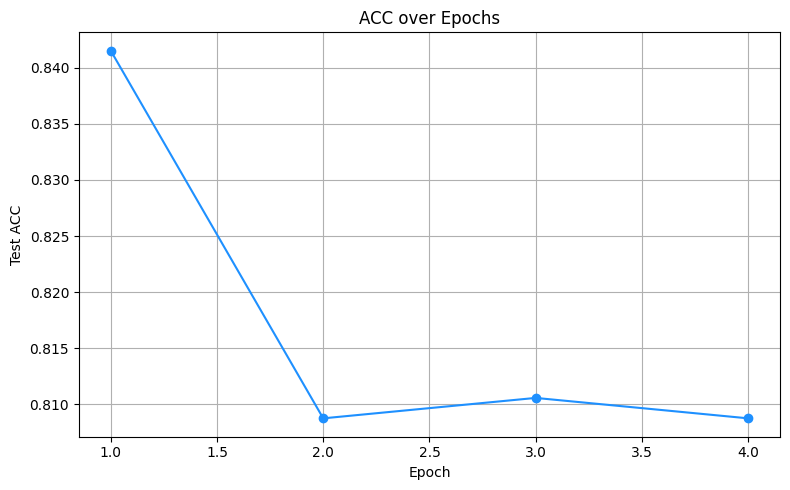

Epoch 005, Loss: 0.4073, Test: 0.8415


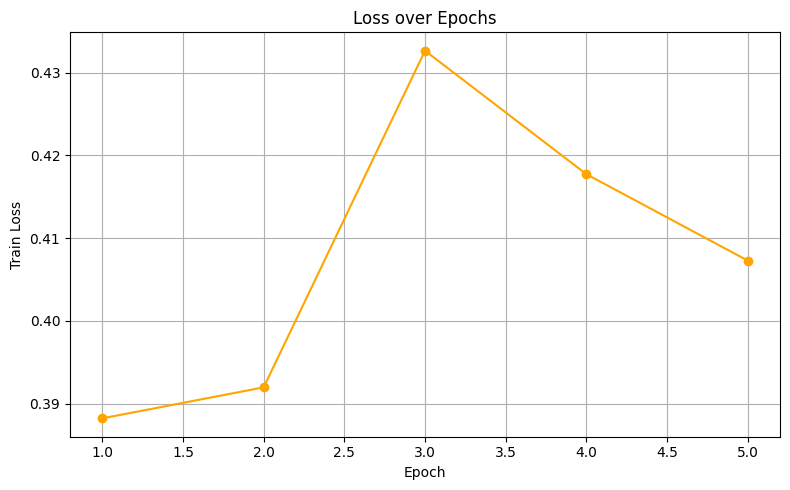

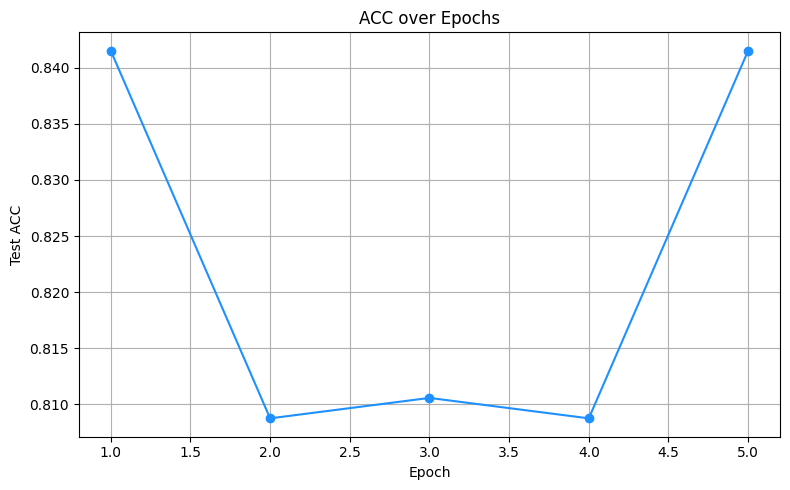

Epoch 006, Loss: 0.4082, Test: 0.8579


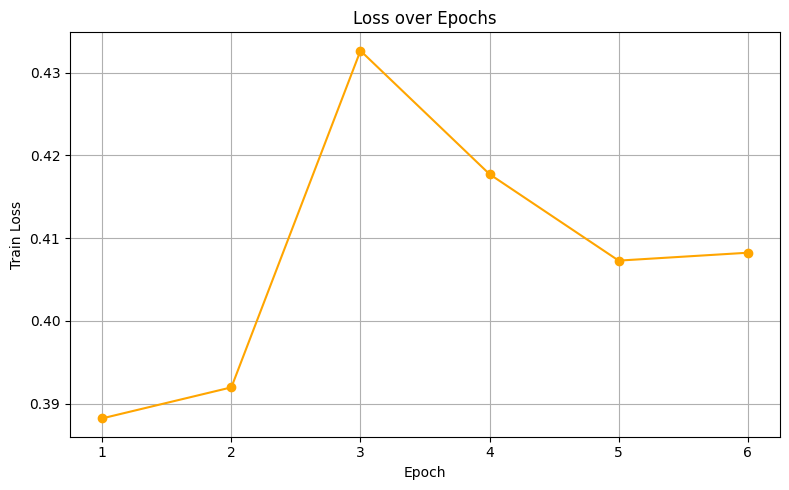

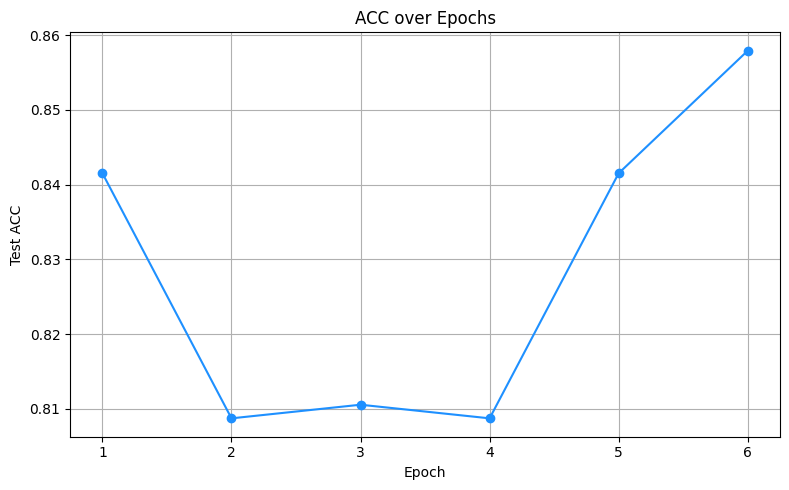

  >> Best model saved at epoch 6 with IoU: 0.8579
Epoch 007, Loss: 0.4016, Test: 0.7960


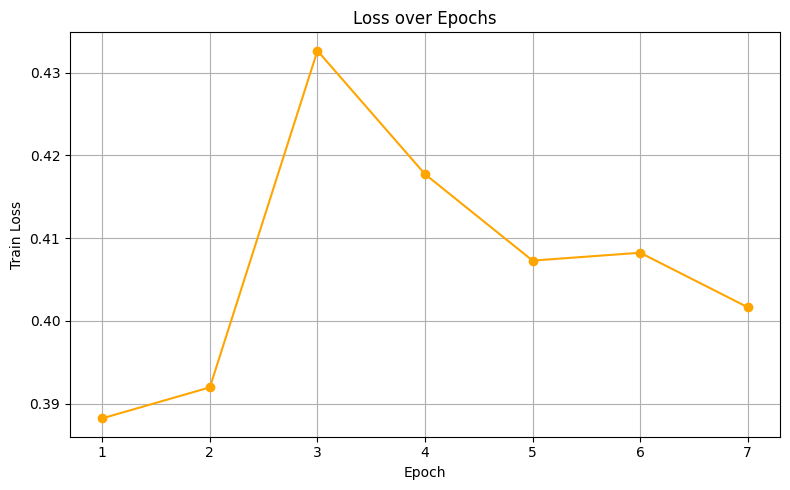

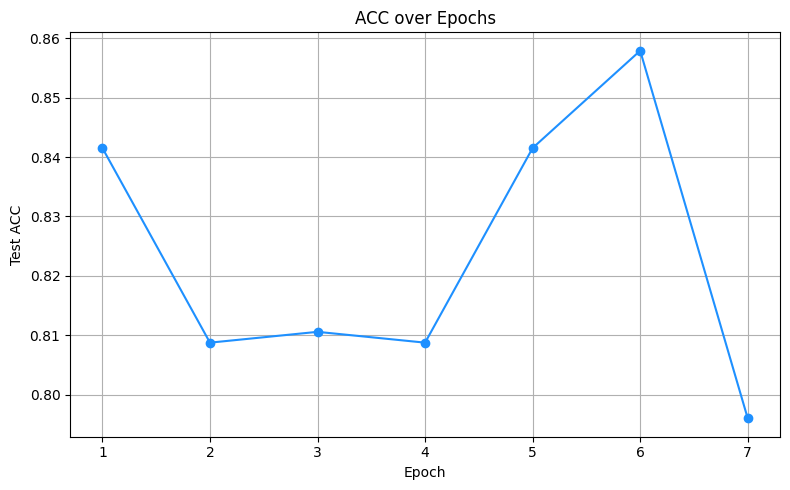

Epoch 008, Loss: 0.4045, Test: 0.8069


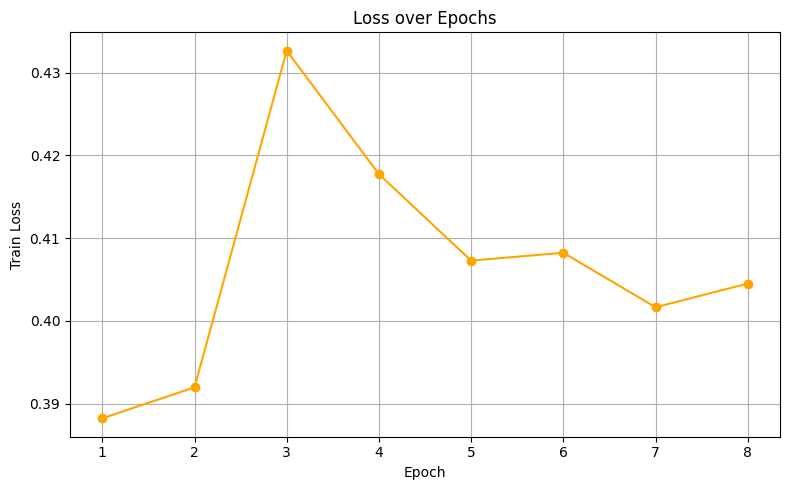

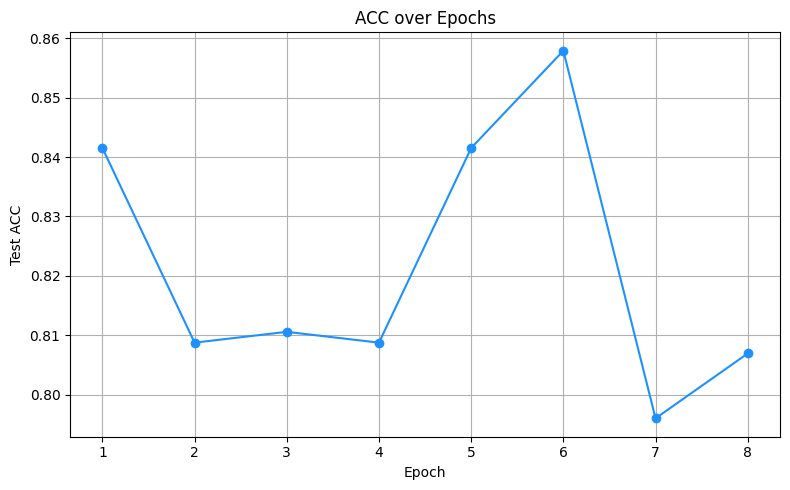

Epoch 009, Loss: 0.4055, Test: 0.8069


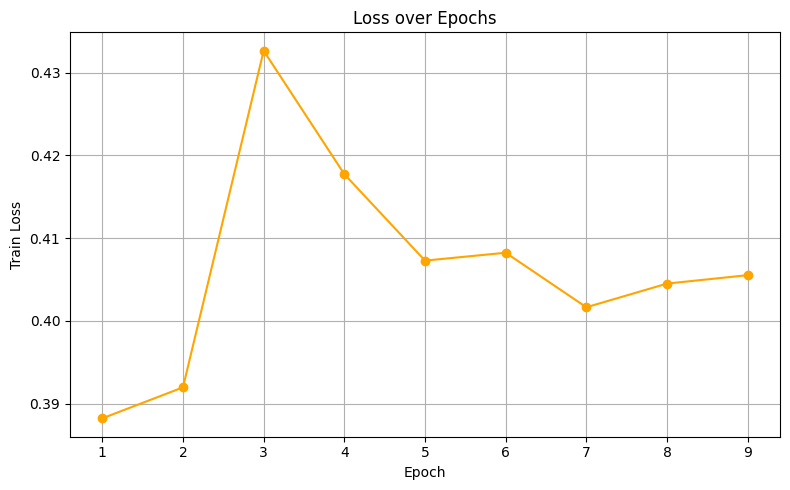

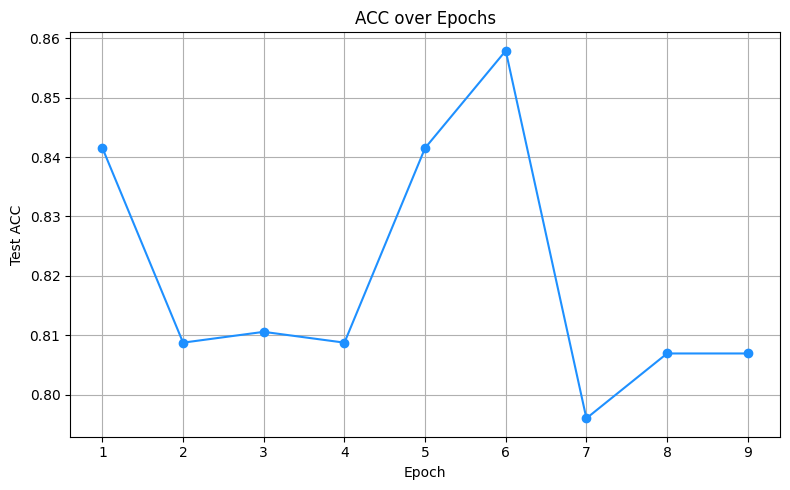

In [ ]:
loss_list = []
iou_list = []

best_iou = 0.0  # or float('-inf') if you're maximizing
best_model_path = "best_model_classify.pth"

def plot_iou_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='dodgerblue')
    plt.title('ACC over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test ACC')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_loss_over_epochs(iou_list):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(iou_list) + 1), iou_list, marker='o', color='orange')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


for epoch in range(1, 101):
        loss = train()
        loss_list.append(loss)
        test_acc = test(test_loader)
        iou_list.append(test_acc)
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}')
        plot_loss_over_epochs(loss_list)
        plot_iou_over_epochs(iou_list)
        if test_acc > best_iou:
          best_iou = test_acc
          torch.save(model.state_dict(), best_model_path)
          print(f"  >> Best model saved at epoch {epoch} with Acc: {best_iou:.4f}")
        scheduler.step()

In [ ]:
model.load_state_dict(torch.load("/content/best_model_for_classify.pth"))

<All keys matched successfully>

#test


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
@torch.no_grad()
def test(loader, return_preds=False,):
    model.eval()
    correct = 0
    all_preds, all_labels = [], []

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.pos, data.batch)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()

        if return_preds:
            all_preds.append(pred.cpu())
            all_labels.append(data.y.cpu())

    acc = correct / len(loader.dataset)

    if return_preds:
        return acc, torch.cat(all_preds), torch.cat(all_labels)
    return acc


Model saved to 'best_model_for_classify.pth'


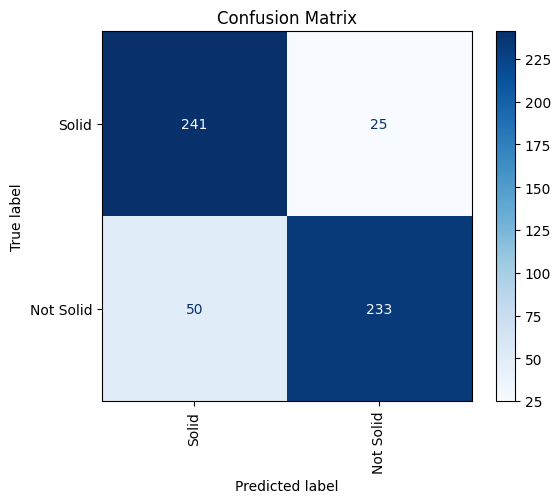

In [ ]:


# ---------- Evaluate with confusion matrix ----------
_, y_pred, y_true = test(test_loader, return_preds=True)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = ["Solid", "Not Solid"])
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
acc, y_pred, y_true = test(test_loader, return_preds=True)

#Fanta

In [ ]:
!rm -r /content/data2

In [ ]:
!unzip /content/processed_fanta_v5.zip -d /content/temp_extract
!mkdir /content/data2
!mkdir /content/data2/raw
!mv /content/temp_extract/processed_fanta_v4/* /content/data2/raw
!rm -r /content/temp_extract

Archive:  /content/processed_fanta_v5.zip
   creating: /content/temp_extract/processed_fanta_v4/
   creating: /content/temp_extract/processed_fanta_v4/abc/
  inflating: /content/temp_extract/processed_fanta_v4/abc/00002.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00003.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00005.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00006.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00008.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00011.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00012.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00013.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00014.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00015.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00016.txt  
  inflating: /content/temp_extract/processed_fanta_v4/abc/00017.txt  
  in

In [ ]:

class FantaBrk(InMemoryDataset):


    url = ('https://shapenet.cs.stanford.edu/media/'
           'shapenetcore_partanno_segmentation_benchmark_v0_normal.zip')

    # In case `shapenet.cs.stanford.edu` is offline, try to download the data
    # from Kaggle instead (requires login):
    # https://www.kaggle.com/datasets/mitkir/shapenet/download?datasetVersionNumber=1

    category_ids = {'All_Statue': 'abc'}



    seg_classes = {'All_Statue': [0, 1]}

    def __init__(
        self,
        root: str,
        categories: Optional[Union[str, List[str]]] = None,
        include_normals: bool = True,
        split: str = 'trainval',
        transform: Optional[Callable] = None,
        pre_transform: Optional[Callable] = None,
        pre_filter: Optional[Callable] = None,
        force_reload: bool = False,
    ) -> None:
        if categories is None:
            categories = list(self.category_ids.keys())
        if isinstance(categories, str):
            categories = [categories]
        print(categories)
        assert all(category in self.category_ids for category in categories)
        self.categories = categories
        super().__init__(root, transform, pre_transform, pre_filter,
                         force_reload=force_reload)

        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'val':
            path = self.processed_paths[1]
        elif split == 'test':
            path = self.processed_paths[2]
        elif split == 'trainval':
            path = self.processed_paths[3]
        else:
            raise ValueError(f'Split {split} found, but expected either '
                             'train, val, trainval or test')

        self.load(path)

        assert isinstance(self._data, Data)
        self._data.x = self._data.x if include_normals else None

        self.y_mask = torch.zeros((len(self.seg_classes.keys()),len(self.seg_classes.keys())*2),
                                  dtype=torch.bool)
        for i, labels in enumerate(self.seg_classes.values()):
            self.y_mask[i, labels] = 1

    @property
    def num_classes(self) -> int:
        return self.y_mask.size(-1)

    @property
    def raw_file_names(self) -> List[str]:
        return list(self.category_ids.values()) + ['train_test_split']

    @property
    def processed_file_names(self) -> List[str]:
        cats = '_'.join([cat[:3].lower() for cat in self.categories])
        return [
            osp.join(f'{cats}_{split}.pt')
            for split in ['train', 'val', 'test', 'trainval']
        ]

    def download(self) -> None:
        pass

    def process_filenames(self, filenames: List[str]) -> List[Data]:
        rank_ids = {'abc': 0}
        data_list = []
        categories_ids = [self.category_ids[cat] for cat in self.categories]
        cat_idx = {categories_ids[i]: i for i in range(len(categories_ids))}

        for name in filenames:
            cat = name.split(osp.sep)[0]
            if cat not in categories_ids:
                continue
            my_custom_idx = rank_ids[cat]
            tensor = read_txt_array(osp.join(self.raw_dir, name))
            pos = tensor[:, :3]
            x = tensor[:, 3:6]
            y = tensor[:, -1].type(torch.long)+2*my_custom_idx
            data = Data(pos=pos, x=x, y=y, category=cat_idx[cat])
            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)
            data_list.append(data)

        return data_list

    def process(self) -> None:
        trainval = []
        for i, split in enumerate(['train', 'val', 'test']):
            path = osp.join(self.raw_dir, 'train_test_split',
                            f'shuffled_{split}_file_list.json')
            with open(path) as f:
                filenames = [
                    osp.sep.join(name.split('/')[1:]) + '.txt'
                    for name in json.load(f)
                ]  # Removing first directory.
            data_list = self.process_filenames(filenames)
            if split == 'train' or split == 'val':
                trainval += data_list
            self.save(data_list, self.processed_paths[i])
        self.save(trainval, self.processed_paths[3])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({len(self)}, '
                f'categories={self.categories})')


In [ ]:
category = None  # Pass in `None` to train on all categories.
path = "/content/data2"
transform = T.Compose([
    T.RandomJitter(0.01),
    T.RandomRotate(15, axis=0),
    T.RandomRotate(15, axis=1),
    T.RandomRotate(15, axis=2)
])

test_dataset2 = FantaBrk(path, category, split='test',
                        pre_transform=pre_transform)
test_loader2 = DataLoader(test_dataset2, batch_size=12, shuffle=False,
                         num_workers=2)

['All_Statue']


Processing...
Done!


In [ ]:
@torch.no_grad()
def use(loader):
    model.eval()
    all_preds = []

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.pos, data.batch)
        pred = out.max(dim=1)[1]
        all_preds.append(pred.cpu())


    return torch.cat(all_preds)


In [ ]:
results = use(test_loader2)

In [ ]:
from collections import Counter
Counter(results.numpy())

Counter({np.int64(1): 136, np.int64(0): 14})

In [ ]:
results.numpy()

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])